# Child Labour Prediction 

The aim of this analysis is to predict households with child labour in Argentina for 2022. I use an XGBoost and a Neural Network model to make a binary classification. Since the EANNA 2016/17 is the latest survey that captures child labour, the prediction is done on the EPH 2021 (Argentina Permanent Household Survey) which is also a household questionnaire and it is conducted more frequently (every four months each year). A limitation of this approach is that I’m forced to select the variables which are the same in both surveys. Luckily, both of them are similar as far as the methodology in which they record each sample.

The training dataset is based on the EANNA 2016/17 Dataset which is made up of 3 surveys. The first survey (C1) is a household survey, it describes the general characteristics of the sample population, including composition by age and sex, residence, household size, education, housing facilities, etc. Each record of C1 represents a household, which is identified with an ID variable (“CODIGO”). The other two questionnaires from the EANNA 2016/17 survey (C2 and C3), describe the characteristics of the individuals living at each house. Each record is also identified with the household ID (“CODIGO”) which links them to a household. This allows me to group by household ID in order to create a single dataframe to use as a training set.

The test set is based on the EPH 2021 which is made up of 2 surveys: 

EPHOG (household characteristics), which is similar to C1.
EPIND: (individuals living at each household) similar to C2 and C3.

Same as EANNA 2016/17, both EPHOG and EPIND use an ID (“CODUSU”).

The goal is to predict how many households in EPH 2021 have child labour and to extract the most relevant variables that contribute to child labour.



In [90]:
import  pandas  as pd
import  matplotlib.pyplot as plt
import numpy as np
import os  
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm     
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import metrics
from tensorflow import keras
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from funciones import missing_values
from functools import reduce
from sklearn.metrics.pairwise import euclidean_distances
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import cv
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers

In [2]:
#Import each dataset

EPHOG = pd.read_csv(r'C:\Users\marti\OneDrive\Escritorio\UDESA\TESIS\Base de datos\usu_hogar_T321.csv', sep=';')
EPIND = pd.read_csv(r'C:\Users\marti\OneDrive\Escritorio\UDESA\TESIS\Base de datos\usu_individual_T321.csv', sep=';')
C1 = pd.read_csv(r'C:\Users\marti\OneDrive\Escritorio\UDESA\TESIS\Base de datos\C1_ EANNA_URBANA_Completa_02.csv', sep=';')
C2 = pd.read_csv(r'C:\Users\marti\OneDrive\Escritorio\UDESA\TESIS\Base de datos\C2_ EANNA URBANA_Completa_07.csv', sep=';')
C3 = pd.read_csv(r'C:\Users\marti\OneDrive\Escritorio\UDESA\TESIS\Base de datos\C3_EANNA_URBANA_Completa_04.csv', sep=';')

C:\Users\marti\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (102) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\marti\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
#Select the variables from EPH which are the same in EANNA

eph_h = EPHOG[['CODUSU','IV2','II7', 'IV6' ,'IV8', 'IV11', 'V5', 'REGION', 'IV1', 'IV3', 'II8', 'IX_MEN10', 'IX_TOT']]
eph_i = EPIND[['CODUSU', 'CH03','CH06', 'CH04', 'CH07', 'ESTADO','CH11']]

In [4]:
#Rename columns so to match them with EANNA

eph_h.columns = ['CODIGO','C1_P04', 'C1_P13', 'C1_P06', 'C1_P09', 'C1_P11', 'Hog_AUH', 'NREGION', 'C1_P01', 'C1_P03', 'DefGas', 'CantPob_0_17', 'TamHog']
eph_i.columns = ['CODIGO', 'C2_P04', 'C2_P02', 'C2_P03', 'C2_P07', 'ESTADO', 'C3_E07']

In [5]:
#Select the variables from EANNA and replace empty values with NaN

eanna_h = C1[['CODIGO','C1_P04', 'C1_P13', 'C1_P06', 'C1_P09', 'C1_P11', 'Hog_AUH', 'NREGION', 'C1_P01', 'C1_P03', 'DefGas', 'CantPob_0_17']]
eanna_h = eanna_h.replace(r'^\s*$', np.nan, regex=True)

eanna_i = C2[['CODIGO', 'C2_P04', 'C2_P02', 'C2_P03', 'C2_P07', 'ESTADO', 'TamHog']]
eanna_i = eanna_i.replace(r'^\s*$', np.nan, regex=True)

eanna_c = C3[['CODIGO','C3_E07', 'Trabaja']]
eanna_c = eanna_c.replace(r'^\s*$', np.nan, regex=True)

In [6]:
#Check if there is any missing value.

missing_values_eanna_h = missing_values(eanna_h)
missing_values_eanna_h


Your selected dataframe has 12 columns.
There are 4 columns that have missing values.


,Missing Values,% of Total Values
Hog_AUH,14363,55.0
C1_P11,257,1.0
C1_P04,20,0.1
C1_P03,20,0.1


In [7]:
missing_values_eanna_c = missing_values(eanna_c)
missing_values_eanna_c


Your selected dataframe has 3 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
C3_E07,1102,6.6


In [8]:
missing_values_eanna_c = missing_values(eanna_i)
missing_values_eanna_c


Your selected dataframe has 7 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [9]:
#Replace missing values with mode. Convert columns to numeric type.

col = ["C3_E07"]
eanna_c[col]=eanna_c[col].fillna(eanna_c.mode().iloc[0])



cols = ["Hog_AUH", "C1_P11", "C1_P04", "C1_P03"]
eanna_h[cols]=eanna_h[cols].fillna(eanna_h.mode().iloc[0])



eanna_c = eanna_c.apply(pd.to_numeric)
eanna_h = eanna_h.apply(pd.to_numeric)
eanna_i = eanna_i.apply(pd.to_numeric)


In [10]:
#Correct columns in EANNA that measure the same variables but with different values


eanna_h.loc[eanna_h["C1_P13"] > 4, "C1_P13"] = 6

eanna_h.loc[eanna_h["C1_P06"] > 3, "C1_P06"] = 3

eanna_h.loc[eanna_h["C1_P09"] > 3, "C1_P09"] = 2

eanna_h.loc[eanna_h["C1_P11"] > 4, "C1_P11"] = 4

eanna_h.loc[eanna_h["C1_P01"] == 5, "C1_P01"] = 4


eanna_h1 = eanna_h.copy()

eanna_h1.loc[eanna_h["C1_P01"] > 5, "C1_P01"] = 5

eanna_h1.loc[eanna_h["C1_P03"] > 3, "C1_P03"] = 3

eanna_h1.loc[eanna_h["DefGas"] == 99, "DefGas"] = 3


eanna_i.loc[eanna_i["C2_P04"] == 99, "C2_P04"] = 10

eanna_i.loc[eanna_i["C2_P07"] == 4, "C2_P07"] = 3

eanna_i1 = eanna_i.copy()

eanna_i.loc[eanna_i["C2_P07"] == 5, "C2_P07"] = 4

eanna_i2 = eanna_i1.copy()

eanna_i2.loc[eanna_i["C2_P07"] == 6, "C2_P07"] = 5

eanna_i3 = eanna_i2.copy()

eanna_i3.loc[eanna_i["C2_P07"] ==9, "C2_P07"] = 5

eanna_i3.loc[eanna_i["ESTADO"] ==9, "ESTADO"] = 3

eanna_i3.loc[eanna_i["ESTADO"] ==97, "ESTADO"] = 4

eanna_i3.loc[eanna_i["ESTADO"] ==98, "ESTADO"] = 3

In [11]:
#Same for EPH

eph_h2 = eph_h.copy()

eph_h2.loc[eph_h2["TamHog"] > 8, "TamHog"] = 7

In [12]:
#Group by household ID  for EPH using mode.

eph_i_h = eph_i.groupby("CODIGO", as_index=False).agg(
    lambda x: pd.Series.mode(x)[0])

#Same for EANNA.

eanna_i_h = eanna_i3.groupby("CODIGO", as_index=False).agg(
    lambda x: pd.Series.mode(x)[0])
eanna_c_h = eanna_c.groupby("CODIGO", as_index=False).agg(
    lambda x: pd.Series.mode(x)[0])


In [13]:
#Check the shape of each df

shapes = {'eph_h': eph_h.shape, 'eph_i_h': eph_i_h.shape, 'eanna_h': eanna_h.shape, 'eanna_c_h': eanna_c_h.shape, 'eanna_i_h': eanna_i_h.shape}
print(shapes)

{'eph_h': (16285, 13), 'eph_i_h': (16150, 7), 'eanna_h': (26115, 12), 'eanna_c_h': (9922, 3), 'eanna_i_h': (26115, 7)}


In [14]:
#Merge household and indvidual dataframe on household ID


eph_df = pd.merge(eph_h2, eph_i_h, how='outer', on ='CODIGO')

dfs_eanna = [eanna_h1, eanna_i_h, eanna_c_h]

eanna_df = reduce(lambda left,right: pd.merge(left,right,on='CODIGO'), dfs_eanna)

print("eanna df shape: ", eanna_df.shape, "eph shape: ", eph_df.shape)

eanna_df


eanna df shape:  (9922, 20) eph shape:  (16285, 19)


,CODIGO,C1_P04,C1_P13,C1_P06,C1_P09,C1_P11,Hog_AUH,NREGION,C1_P01,C1_P03,DefGas,CantPob_0_17,C2_P04,C2_P02,C2_P03,C2_P07,ESTADO,TamHog,C3_E07,Trabaja
0,1100,3,1,1,1,1,2,1,2,1,0,1,3,5,1,5,1,5,1,0
1,1101,4,1,1,1,1,2,1,5,1,0,2,3,2,1,2,1,4,1,0
2,1219,3,3,1,1,1,2,1,5,1,0,2,3,8,1,1,1,4,1,0
3,1275,5,2,1,1,1,2,1,1,1,0,2,3,6,2,5,4,3,2,0
4,1416,3,1,1,1,1,2,1,1,1,1,1,3,10,2,5,1,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9917,64799,3,3,1,1,1,2,44,1,1,0,1,1,15,2,1,1,3,2,0
9918,64809,3,3,1,1,1,2,44,1,1,0,1,1,12,2,5,1,2,2,0
9919,64815,4,1,1,1,1,2,44,1,1,0,4,6,16,2,5,4,7,1,0
9920,64819,2,1,2,2,1,2,44,1,2,1,1,1,15,1,2,3,3,1,0


In [15]:
#Reorder colums so that eanna_df and eph_df match

eph_df = eph_df[['CODIGO', 'C1_P13', 'C1_P06', 'C1_P09', 'C1_P11', 'Hog_AUH',
       'NREGION', 'C1_P01', 'C1_P03', 'DefGas', 'C2_P03', 'C2_P07', 'ESTADO', 'C3_E07', 'C2_P04', 'CantPob_0_17', 'C2_P02']]

eanna_df= eanna_df[['CODIGO', 'C1_P13', 'C1_P06', 'C1_P09', 'C1_P11', 'Hog_AUH',
       'NREGION', 'C1_P01', 'C1_P03', 'DefGas', 'C2_P03', 'C2_P07', 'ESTADO', 
                    'C3_E07','C2_P04', 'CantPob_0_17', 'C2_P02', 'Trabaja']]



In [16]:
X = eanna_df.drop(['Trabaja','CODIGO'], axis=1)
y = eanna_df['Trabaja']

eph_pred = eph_df.drop(['CODIGO'], axis=1)



In [17]:
#Check if the eanna_df (training dataset) is balanced


t = eanna_df['Trabaja'].sum()

print("Percentage of households with child labour: ", t/len(y))


Percentage of households with child labour:  0.06611570247933884


In [18]:
#Since the dataset is not balanced, I use SMOTENC to solve this.


sm = SMOTENC(categorical_features=[0,13], random_state=123, sampling_strategy=.6)
X_res, y_res = sm.fit_resample(X, y)



print("Percentage of households with child labour: ", y_res.sum() / len(y_res))

Percentage of households with child labour:  0.37497470489038787


In [384]:
len(X_res)

14825

In [385]:
len(eph_pred)

16285

In [19]:
#Create list with categorical features' names.
categorical_c = ['C1_P13', 'C1_P06', 'C1_P09', 'C1_P11', 'Hog_AUH',
       'NREGION', 'C1_P01', 'C1_P03', 'DefGas', 'C2_P03', 'C2_P07', 'ESTADO', 'C3_E07']


#Create list with numerical features' names.
numeric = ['C2_P04','CantPob_0_17', 'C2_P02']

In [20]:

categorical = eanna_df[categorical_c].astype('category')


# pipeline for numerical columns
num_pipe = make_pipeline(StandardScaler())

# pipeline for categorical columns
cat_pipe = make_pipeline(OneHotEncoder(handle_unknown='ignore')
)

# combine both the pipelines
preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric),
    ('cat', cat_pipe, categorical_c)
])


# XGBOOST

In [21]:

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", xgb.XGBClassifier())]
)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=0)



clf.fit(X_train, y_train)

print("model score: %.3f" % clf.score(X_test, y_test))


model score: 0.869


In [22]:
dm_train = xgb.DMatrix(X_train, label=y_train)
dm_test = xgb.DMatrix(X_test, label=y_test)

In [24]:
#Building Model

#Ideal case would include an exhaustive gridsearch on all the parameters but its computationally intensive.
#So I'll focus on few important parameters and tune them sequentially using logistic loss function.

# PARAMETERES:
# 1. max_depth
# 2. min_child_weight
# 3. subsample
# 4. colsample_bytree
# 5. eta
# 6. num_boost_rounds
# 7. early_stopping_rounds


params = {'max_depth':6, 'min_child_weight':1, 'eta':0.3, 'subsample':1, 
          'colsample_bytree':1, 'objective':'binary:logistic',}




# We will use logloss function to evaluate the model's performance
params['eval_metric'] = "logloss"

xgmodel = xgb.train(params, dtrain = dm_train, num_boost_round = 300, evals = [(dm_test,"Test")], 
                    early_stopping_rounds = 10)

print("Best Logloss: {:.3f} | Rounds: {}".format(xgmodel.best_score,xgmodel.best_iteration+1))

[0]	Test-logloss:0.61516
[1]	Test-logloss:0.56980
[2]	Test-logloss:0.53921
[3]	Test-logloss:0.51494
[4]	Test-logloss:0.49439
[5]	Test-logloss:0.48240
[6]	Test-logloss:0.47134
[7]	Test-logloss:0.46382
[8]	Test-logloss:0.44970
[9]	Test-logloss:0.44284
[10]	Test-logloss:0.43636
[11]	Test-logloss:0.43226
[12]	Test-logloss:0.42865
[13]	Test-logloss:0.42551
[14]	Test-logloss:0.41684
[15]	Test-logloss:0.41421
[16]	Test-logloss:0.40860
[17]	Test-logloss:0.40550
[18]	Test-logloss:0.40265
[19]	Test-logloss:0.40057
[20]	Test-logloss:0.39676
[21]	Test-logloss:0.39574
[22]	Test-logloss:0.39430
[23]	Test-logloss:0.39306
[24]	Test-logloss:0.39181
[25]	Test-logloss:0.38990
[26]	Test-logloss:0.38879
[27]	Test-logloss:0.38730
[28]	Test-logloss:0.38666
[29]	Test-logloss:0.38235
[30]	Test-logloss:0.38171
[31]	Test-logloss:0.37915
[32]	Test-logloss:0.37769
[33]	Test-logloss:0.37585
[34]	Test-logloss:0.37566
[35]	Test-logloss:0.37542
[36]	Test-logloss:0.37536
[37]	Test-logloss:0.37524
[38]	Test-logloss:0.37

In [27]:
#Cross validation is used to tune the parameters within the params dictionary.

gridsearch_params = [(max_depth, min_child_weight)
                    for max_depth in range(7,10)
                    for min_child_weight in range(1,4)]

In [29]:
logloss_min = float("Inf")
best_params = None

for max_depth, min_child_weight in gridsearch_params:
    
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    
    xg_cvresults = xgb.cv(params, dtrain = dm_train, num_boost_round = 230,
                      seed = 0, nfold=10, metrics = {'logloss'}, early_stopping_rounds = 10,)
    
    logloss_mean = xg_cvresults['test-logloss-mean'].min()
    
    print("max_depth: {} | min_child_weight: {} with Logloss: {:.3}\n".format(max_depth,min_child_weight,logloss_mean))
    
    if logloss_mean < logloss_min:
        logloss_min = logloss_mean
        best_params = (max_depth, min_child_weight)

        
print("Best Parameters: max_depth: {} | min_child_weight: {} with Logloss: {:.3f}". format(best_params[0], 
                                                                                  best_params[1], logloss_min))

max_depth: 7 | min_child_weight: 1 with Logloss: 0.3

max_depth: 7 | min_child_weight: 2 with Logloss: 0.303

max_depth: 7 | min_child_weight: 3 with Logloss: 0.304

max_depth: 8 | min_child_weight: 1 with Logloss: 0.295

max_depth: 8 | min_child_weight: 2 with Logloss: 0.299

max_depth: 8 | min_child_weight: 3 with Logloss: 0.296

max_depth: 9 | min_child_weight: 1 with Logloss: 0.291

max_depth: 9 | min_child_weight: 2 with Logloss: 0.293

max_depth: 9 | min_child_weight: 3 with Logloss: 0.296

Best Parameters: max_depth: 9 | min_child_weight: 1 with Logloss: 0.291


In [30]:
# Updating the parameters

params['max_depth'] = 9
params['min_child_weight'] = 1

In [31]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(5,11)]
    for colsample in [i/10. for i in range(5,11)]]

In [32]:
logloss_min = float("Inf")
best_params = None

for subsample, colsample in (gridsearch_params):
    
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    
    xg_cvresults = xgb.cv(params, dtrain = dm_train, num_boost_round = 230,
                      seed = 0, nfold=10, metrics = {'logloss'}, early_stopping_rounds = 10,)
    
    logloss_mean = xg_cvresults['test-logloss-mean'].min()
    
    print("subsample: {} | colsample: {} with Logloss: {:.3f}\n".format(subsample,colsample,logloss_mean))
    
    if logloss_mean < logloss_min:
        logloss_min = logloss_mean
        best_params = (subsample, colsample)
        
print("Best Parameters: subsample: {} | colsample: {} with Logloss: {:.3f}". format(best_params[0], 
                                                                           best_params[1], logloss_min))

subsample: 0.5 | colsample: 0.5 with Logloss: 0.304

subsample: 0.5 | colsample: 0.6 with Logloss: 0.302

subsample: 0.5 | colsample: 0.7 with Logloss: 0.301

subsample: 0.5 | colsample: 0.8 with Logloss: 0.299

subsample: 0.5 | colsample: 0.9 with Logloss: 0.296

subsample: 0.5 | colsample: 1.0 with Logloss: 0.297

subsample: 0.6 | colsample: 0.5 with Logloss: 0.303

subsample: 0.6 | colsample: 0.6 with Logloss: 0.299

subsample: 0.6 | colsample: 0.7 with Logloss: 0.298

subsample: 0.6 | colsample: 0.8 with Logloss: 0.290

subsample: 0.6 | colsample: 0.9 with Logloss: 0.293

subsample: 0.6 | colsample: 1.0 with Logloss: 0.294

subsample: 0.7 | colsample: 0.5 with Logloss: 0.300

subsample: 0.7 | colsample: 0.6 with Logloss: 0.295

subsample: 0.7 | colsample: 0.7 with Logloss: 0.297

subsample: 0.7 | colsample: 0.8 with Logloss: 0.289

subsample: 0.7 | colsample: 0.9 with Logloss: 0.291

subsample: 0.7 | colsample: 1.0 with Logloss: 0.289

subsample: 0.8 | colsample: 0.5 with Logloss: 

In [33]:
params['subsample'] = 0.9
params['colsample_bytree'] = 0.9

In [108]:


logloss_min = float("Inf")
best_params = None

for eta in [0.3, 0.2, 0.1, 0.05, 0.01, 0.005]:
    
    params['eta'] = eta
    
    xg_cvresults = xgb.cv(params, dtrain = dm_train, num_boost_round = 200,
                      seed = 0, nfold=10, metrics = {'logloss'}, early_stopping_rounds = 10,)
    
    logloss_mean = xg_cvresults['test-logloss-mean'].min()
    print("eta: {} with Logloss: {:.3}\n".format(eta,logloss_mean))
    
    if logloss_mean < logloss_min:
        logloss_min = logloss_mean
        best_params = eta
        
print("Best Parameter: eta: {} with Logloss: {:.3f}". format(best_params, logloss_min))

eta: 0.3 with Logloss: 0.292

eta: 0.2 with Logloss: 0.293

eta: 0.1 with Logloss: 0.31

eta: 0.05 with Logloss: 0.339

eta: 0.01 with Logloss: 0.447

eta: 0.005 with Logloss: 0.509

Best Parameter: eta: 0.3 with Logloss: 0.292


In [34]:
params['eta'] = 0.3

In [35]:
params

{'max_depth': 9,
 'min_child_weight': 1,
 'eta': 0.3,
 'subsample': 0.9,
 'colsample_bytree': 0.9,
 'objective': 'binary:logistic',
 'eval_metric': 'logloss'}

In [36]:
# Init classifier
xgb_cl = xgb.XGBClassifier(**params)


xgb_cl.fit(X_train, y_train)

preds = xgb_cl.predict(X_test)


print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))
print("model score: %.3f" % xgb_cl.score(X_test, y_test))



[[1699  160]
 [ 128  978]]
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1859
           1       0.86      0.88      0.87      1106

    accuracy                           0.90      2965
   macro avg       0.89      0.90      0.90      2965
weighted avg       0.90      0.90      0.90      2965

model score: 0.903


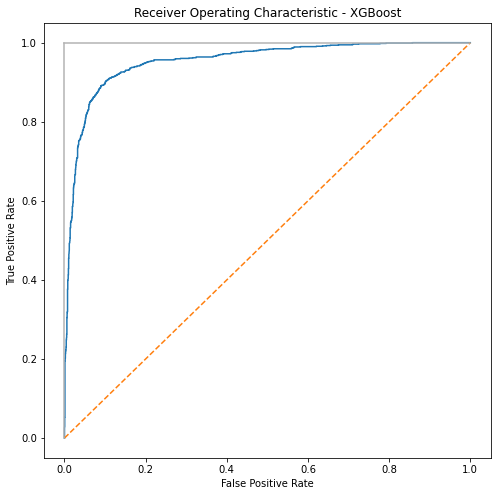

In [88]:
y_score1 = xgb_cl.predict_proba(X_test)[:,1]
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
plt.subplots(1, figsize=(8,8))
plt.title('Receiver Operating Characteristic - XGBoost')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('ROC.png')
plt.show()


In [393]:
auc = round(metrics.roc_auc_score(y_test, y_score1),4)
print(auc)

0.9529


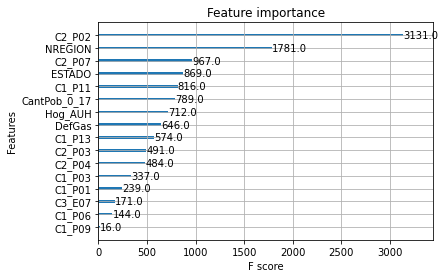

<Figure size 720x2880 with 0 Axes>

In [43]:
#Importance of each variable

xgb.plot_importance(xgb_cl)
plt.figure(figsize = (10, 40))
plt.savefig('Feature.png')
plt.show()


In [145]:
#Prediction for EPH 2021 dataset


final_prediction = xgb_cl.predict(eph_pred)



eph_pred_final = pd.DataFrame(final_prediction, columns = ['Trabaja'])

t1 = eph_pred_final['Trabaja'].sum()
p2 = t1/len(eph_pred_final) 

print( "Percentage of households with child labour: ", p2*100)

Percentage of households with child labour:  18.329751304881793


# NEURAL NETWORK

In [45]:
X_Train = np.array(X_train)
y_Train = np.array(y_train)
X_Test = np.array(X_test)
y_Test = np.array(y_test)

In [371]:
# build a model
model = Sequential()
model.add(Dense(100, input_shape=(X_train.shape[1],), activation='relu')) 
model.add(layers.Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary() 

# compile the model
model.compile(optimizer='Adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# early stopping callback
# This callback will stop the training when there is no improvement in the validation loss for 10 consecutive epochs.  

es = EarlyStopping(monitor='val_accuracy', 
                                   mode='max', 
                                   patience= 20,
                                   restore_best_weights=True)


history = model.fit(X_Train,
                    y_Train,
                    callbacks=[es],
                    epochs=200, 
                    batch_size= 64,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)



Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_197 (Dense)           (None, 100)               1700      
                                                                 
 dropout_90 (Dropout)        (None, 100)               0         
                                                                 
 dense_198 (Dense)           (None, 100)               10100     
                                                                 
 dropout_91 (Dropout)        (None, 100)               0         
                                                                 
 dense_199 (Dense)           (None, 100)               10100     
                                                                 
 dropout_92 (Dropout)        (None, 100)               0         
                                                                 
 dense_200 (Dense)           (None, 1)               

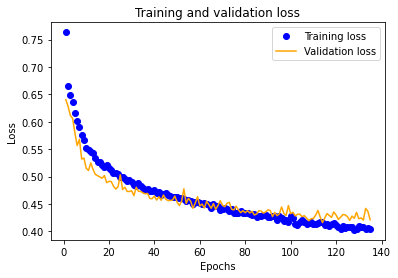

In [372]:
#Plotting the training and validation loss

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']


epochs = range(1, len(loss_values) + 1) 

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

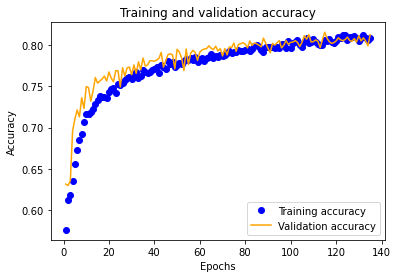

0.8153457045555115

In [373]:
#Plotting the training and validation accuracy

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'bo', label='Training accuracy')

plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


np.max(val_acc)

In [374]:
predi = np.round(model.predict(X_Test),0)


print(confusion_matrix(y_Test, predi)) 

print(classification_report(y_Test, predi))

[[1519  340]
 [ 252  854]]
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1859
           1       0.72      0.77      0.74      1106

    accuracy                           0.80      2965
   macro avg       0.79      0.79      0.79      2965
weighted avg       0.80      0.80      0.80      2965



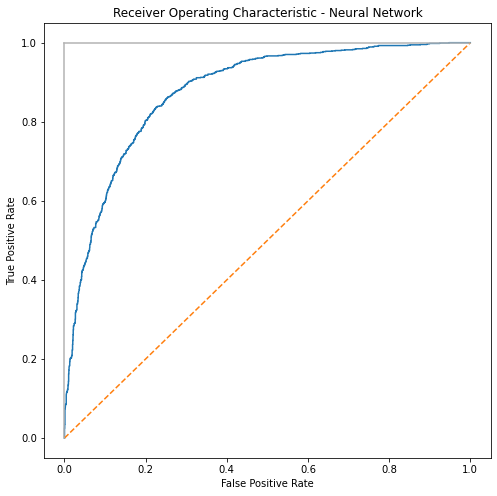

In [390]:
def predict_prob(number):
  return [number[0],1-number[0]]

y_prob = np.array(list(map(predict_prob, model.predict(X_Test))))[:, 1]
y_prob = 1-y_prob 

false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_Test, y_prob)
plt.subplots(1, figsize=(8,8))
plt.title('Receiver Operating Characteristic - Neural Network')
auc = round(metrics.roc_auc_score(y_Test, y_prob), 4)
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('ROC.png')
plt.show()

In [401]:
auc = round(metrics.roc_auc_score(y_Test, y_prob), 4)
auc

0.8767

In [402]:

final_prediction = model.predict(eph_pred)

eph_pred_final2 = pd.DataFrame(final_prediction, columns = ['Trabaja'])
eph_pred_final2['t'] = np.where(eph_pred_final2['Trabaja'] > 0.5, 1, 0)

t1 = eph_pred_final2['t'].sum()
p2 = t1/len(eph_pred_final2) 

print("Percentage of households with child labour: ", p2*100)

Percentage of households with child labour:  71.18821000921093


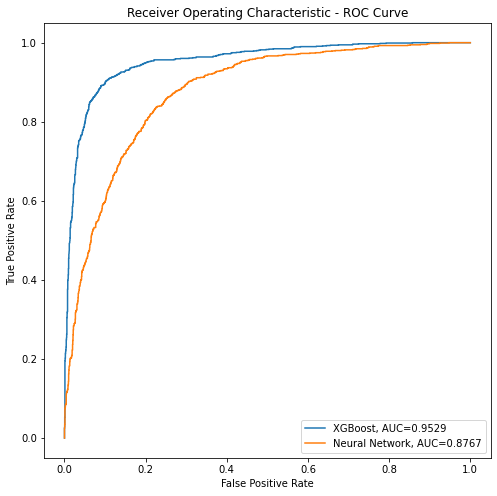

In [403]:


y_pred = xgb_cl.predict_proba(X_test)[:, 1]

plt.subplots(1, figsize=(8,8))
plt.title('Receiver Operating Characteristic - ROC Curve')
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="XGBoost, AUC="+str(auc))


fpr, tpr, _ = metrics.roc_curve(y_Test, y_prob)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Neural Network, AUC="+str(auc1))

#add legend
plt.legend()

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('ROC.png')
plt.show()